### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# install local geoopt first: !pip install -e data/geoopt
import geoopt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import spearmanr

import _utils
from _utils import set_all_seeds, set_plt_layout
from _utils import calculate_reconstruction_metrics, calculate_correlation_metrics_cellcycle
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

_utils.reset_plt_layout()
set_all_seeds(0); set_plt_layout()

### Loading data

In [3]:
# load dataset
adata = ad.read_h5ad('data/cellcycle/velocity_anndata_human_fibroblast_DeepCycle_ISMARA.h5ad')
adata.X = adata.X.toarray() 

leiden_mask = adata.obs['leiden'].astype(int) == 1
adata.obs["color"] = adata.obs['cell_cycle_theta'].where(~leiden_mask, other=np.nan)

df = pd.read_csv('data/cellcycle/QuickGO-annotations-human.tsv', sep='\t')
df.columns = ['product_db', 'product_id', 'symbol', 'go_id', 'go_name', 'taxon', 'db', 'go_aspect']
df = df[df['db'] == 'Ensembl']
df = df.drop_duplicates(subset=['symbol'])

adata = adata[:, adata.var.index.isin(df['symbol'])]

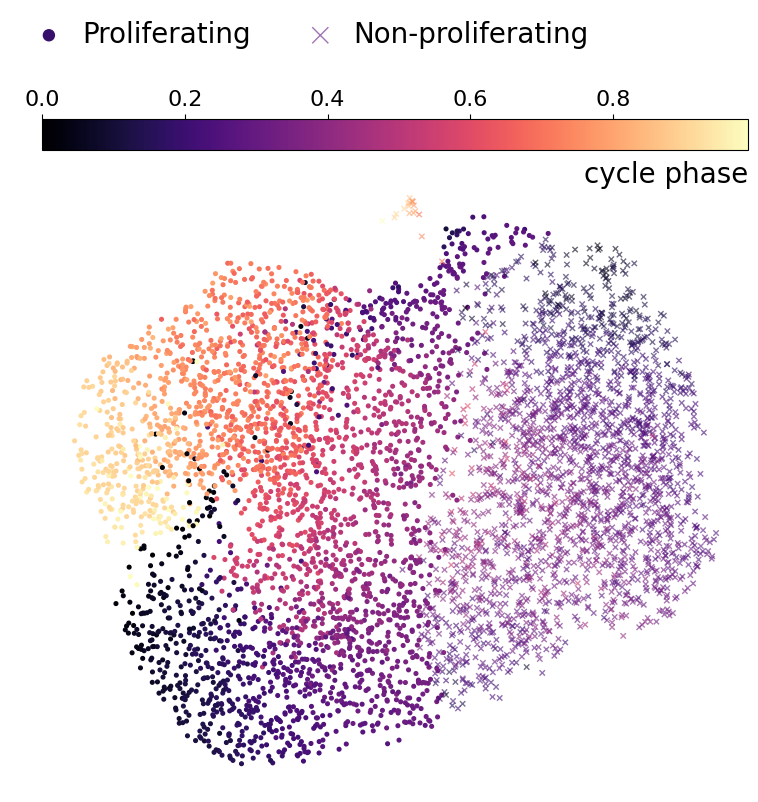

In [4]:
# plot umap with cell_cycle_theta color
fig, ax = plt.subplots(figsize=(8, 8))
umap_x = adata.obsm["X_umap"][:, 0]
umap_y = adata.obsm["X_umap"][:, 1]
color = adata.obs["cell_cycle_theta"].values
valid_mask = ~np.isnan(adata.obs["color"].values)
nan_mask = np.isnan(adata.obs["color"].values)

cmap = "magma"
sc1 = ax.scatter(
    umap_x[valid_mask],
    umap_y[valid_mask],
    c=color[valid_mask],
    cmap=cmap,
    s=7,
    alpha=1,
    label="Proliferating",
)

sc2 = None
if np.any(nan_mask):
    sc2 = ax.scatter(
        umap_x[nan_mask],
        umap_y[nan_mask],
        c=color[nan_mask],
        s=15,
        cmap=cmap,
        alpha=0.6,
        marker="x",
        label="Non-proliferating",
        linewidths=1
    )

# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")

# Place colorbar on top, but move label to the right of the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.2)
cb = fig.colorbar(sc1, cax=cax, orientation="horizontal")
cb.set_label("")
cax.text(1, -0.8, "cycle phase", va='center', ha='right', fontsize=cb.ax.yaxis.label.get_size(), transform=cax.transAxes, rotation=0)

cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

# Make the legend horizontal on top
handles = [sc1]
labels = ["Proliferating"]
if sc2 is not None:
    handles.append(sc2)
    labels.append("Non-proliferating")

legend = ax.legend(
    handles=handles, 
    labels=labels, 
    markerscale=3, 
    loc="upper center",
    bbox_to_anchor=(0.372, 1.28),
    frameon=False,
    framealpha=0.8,
    fancybox=True,
    title_fontsize=20,
    handletextpad=0.2,
    ncol=2,
    columnspacing=1.5,
    fontsize=20
)
legend.get_frame().set_linewidth(0.8)
plt.tight_layout()
# plt.savefig("results/pngs/cc_umap_noax2m_noaxes.png", dpi=300, bbox_inches="tight")
# plt.savefig("results/pdfs/cc_umap_noax2m_noaxes.pdf", dpi=300, bbox_inches="tight")
plt.show() 


In [5]:
# Define RNA dataset class and data loaders
class RNA(Dataset):
    def __init__(self, dataset, subset=None):
        self.data = dataset[subset] if subset is not None else dataset
        self.genes = self.data.var_names.values
        self.cells = self.data.obs_names.values
        self.obs = self.data.obs.copy()
        self.data = torch.from_numpy(self.data.X).double()
        print(self.data.shape)
        
    def __len__(self):
        # return the number of examples in the dataset
        return len(self.data)

    def __getitem__(self, index):
        # return the preprocessed data for the specified example
        return index, self.data[index], np.nan
    

set_all_seeds(0)

# Split data into train, validation and test sets (82/9/9)
indices = np.arange(len(adata))
np.random.shuffle(indices)

train_size = int(0.82 * len(indices))
val_size = int(0.09 * len(indices))
test_size = len(indices) - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_data = RNA(adata, train_indices)
val_data = RNA(adata, val_indices)
test_data = RNA(adata, test_indices)

batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)


torch.Size([4400, 189])
torch.Size([483, 189])
torch.Size([484, 189])


### Model definition

In [6]:
# ---------------------------------
# - Riemannian generative decoder - 
# ---------------------------------

class RGD(nn.Module):
    def __init__(self, dim_list, manifold=geoopt.manifolds.Euclidean()):
        super(RGD, self).__init__()
        self.dim_list = dim_list
        self.manifold = manifold 
        self.origin = self.manifold.origin(dim_list[0], seed=None, device=device)

        # fc decoder stack with swish activations 
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i != len(dim_list) - 2: # only activations for hidden layers
                layers.append(nn.SiLU())
        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        return self.decoder(z)

    def init_samples(self, n):
        # manifold-projected points with small noise opposite origin 
        z = -torch.ones(n, self.dim_list[0], device=device) * self.origin
        z = self.manifold.projx(z)
        return geoopt.ManifoldParameter(z, manifold=self.manifold, requires_grad=True)

from _train import train_rgd
torch.set_default_dtype(torch.float64) 


### Sphere

In [ ]:
# define parameters 
device = "cuda:1"
dim_list = [3, 16, 32, 64, 128, 256, train_data.data.shape[1]]
manifold = geoopt.manifolds.SphereExact()

# initialize and train model
model_sphere = RGD(dim_list, manifold)
model_sphere.z = model_sphere.init_samples(len(train_data))
model_sphere.z_val = model_sphere.init_samples(len(val_data))
train_rgd(model_sphere, F.mse_loss, train_loader, val_loader, [4e-1,2e-3], betas=(0.7,0.9), n_epochs=800, 
    device=device, patience=85, start_saving=150, wd=1e-4, use_amsgrad=False, use_prior=False)

# find test-time representations 
loss_fn = lambda x, y: F.mse_loss(x, y, reduction='none')
ztest = _utils.get_representations(model_sphere, test_loader, loss_fn, n_start_points_per_sample=100, n_epochs=400, lr=4e-1, betas=(0.5, 0.7), wd=0, device=device)
model_sphere.z_test = ztest

# Compute results 
pearson, spearman = calculate_correlation_metrics_cellcycle(model_sphere.z, manifold, train_data)
test_pearson, test_spearman = calculate_correlation_metrics_cellcycle(model_sphere.z_test, manifold, test_data)
train_mae, train_mse = calculate_reconstruction_metrics(model_sphere, model_sphere.z, train_data)
test_mae, test_mse = calculate_reconstruction_metrics(model_sphere, model_sphere.z_test, test_data)
print(f"Train: Pearson={round(pearson, 3)}, Spearman={round(spearman, 3)}, MAE={round(train_mae, 3)}, MSE={round(train_mse, 3)}")
print(f" Test: Pearson={round(test_pearson, 3)}, Spearman={round(test_spearman, 3)}, MAE={round(test_mae, 3)}, MSE={round(test_mse, 3)}")

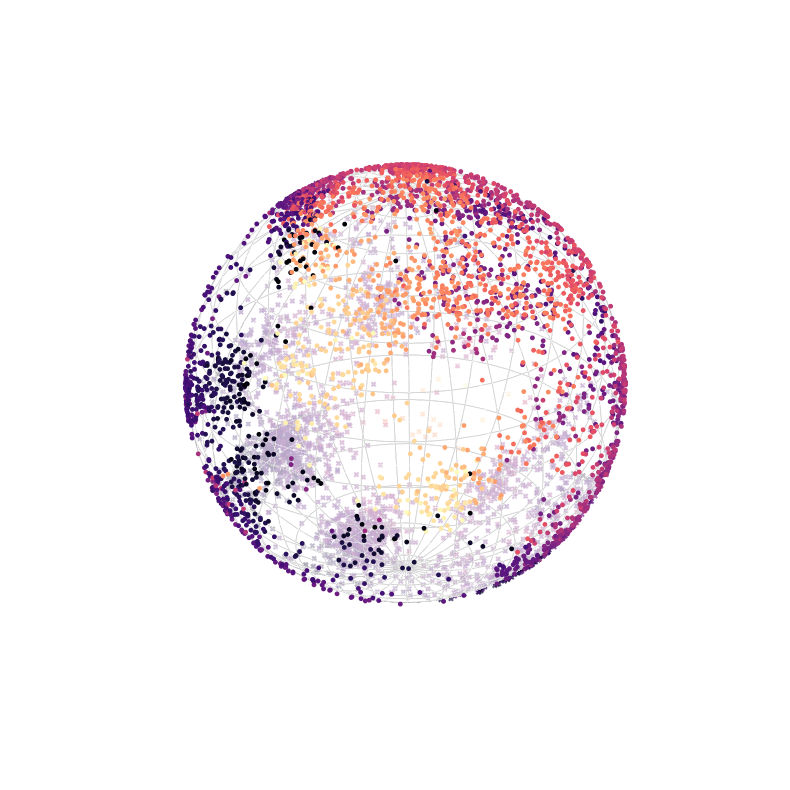

In [8]:
# Prepare data: concatenate train, val, test for z and colors from m_sphere3
z = np.concatenate([
    model_sphere.z.detach().cpu().numpy(),
    model_sphere.z_val.detach().cpu().numpy(),
    model_sphere.z_test.detach().cpu().numpy()
], axis=0)

labels = np.concatenate([
    train_data.obs.cell_cycle_theta.values,
    val_data.obs.cell_cycle_theta.values,
    test_data.obs.cell_cycle_theta.values
], axis=0)

color_col = pd.concat([
    train_data.obs["color"],
    val_data.obs["color"],
    test_data.obs["color"]
], axis=0).reset_index(drop=True)
is_nonprolif = color_col.isna().values

cmap = "magma"
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot proliferating cells (scatter, colored by label)
sc1 = ax.scatter(
    z[~is_nonprolif, 0],
    z[~is_nonprolif, 1],
    z[~is_nonprolif, 2],
    c=labels[~is_nonprolif],
    cmap=cmap,
    s=6,
    alpha=1,
    label="Proliferating"
)

# Plot non-proliferating cells as 'x'
sc2 = ax.scatter(
    z[is_nonprolif, 0],
    z[is_nonprolif, 1],
    z[is_nonprolif, 2],
    c=labels[is_nonprolif],
    cmap=cmap,
    s=9,
    alpha=0.7,
    marker="x",
    label="Non-proliferating",
    linewidths=1 
)

ax.set_axis_off()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# generate sphere mesh
u = np.linspace(0, 2 * np.pi, 60)
v = np.linspace(0, np.pi, 30)
u, v = np.meshgrid(u, v)

R = 0.99  # sphere radius
X = R * np.cos(u) * np.sin(v)
Y = R * np.sin(u) * np.sin(v)
Z = R * np.cos(v)

# Plot the sphere wireframe
ax.plot_wireframe(
    X, Y, Z,
    rstride=2, cstride=2,
    color='k',
    linewidth=0.5,
    alpha=1,
)

# Plot the sphere as a translucent surface (volume)
ax.plot_surface(
    X, Y, Z,
    color='white',
    alpha=0.4,
    linewidth=0,
    antialiased=False,
    shade=False
)

ax.set_box_aspect((1, 1, 1))
ax.view_init(elev=30, azim=60)

plt.tight_layout()
# plt.savefig('results/pdfs/cc_sphere_finalm.pdf', dpi=400, bbox_inches='tight', pad_inches=0)
# plt.savefig('results/pngs/cc_sphere_finalm.png', dpi=400, bbox_inches='tight')
plt.show()


### Torus


In [ ]:
# define parameters 
device = "cuda:1"
dim_list = [4, 16, 32, 64, 128, 256, train_data.data.shape[1]]
s = geoopt.manifolds.SphereExact(); manifold = geoopt.ProductManifold((s, 2), (s, 2))

# initialize and train model
model_torus = RGD(dim_list, manifold)
model_torus.z = model_torus.init_samples(len(train_data))
model_torus.z_val = model_torus.init_samples(len(val_data))
train_rgd(model_torus, F.mse_loss, train_loader, val_loader, [4e-1,2e-3], betas=(0.7,0.9), n_epochs=800, 
    device=device, patience=85, start_saving=150, wd=1e-4, use_amsgrad=False, use_prior=False)

# find test-time representations 
loss_fn = lambda x, y: F.mse_loss(x, y, reduction='none')
ztest = _utils.get_representations(model_torus, test_loader, loss_fn, n_start_points_per_sample=100, n_epochs=400, lr=4e-1, betas=(0.5, 0.7), wd=0, device=device)
model_torus.z_test = ztest

# Compute results 
pearson, spearman = calculate_correlation_metrics_cellcycle(model_torus.z, manifold, train_data)
test_pearson, test_spearman = calculate_correlation_metrics_cellcycle(model_torus.z_test, manifold, test_data)
train_mae, train_mse = calculate_reconstruction_metrics(model_torus, model_torus.z, train_data)
test_mae, test_mse = calculate_reconstruction_metrics(model_torus, model_torus.z_test, test_data)
print(f"Train: Pearson={round(pearson, 3)}, Spearman={round(spearman, 3)}, MAE={round(train_mae, 3)}, MSE={round(train_mse, 3)}")
print(f" Test: Pearson={round(test_pearson, 3)}, Spearman={round(test_spearman, 3)}, MAE={round(test_mae, 3)}, MSE={round(test_mse, 3)}")

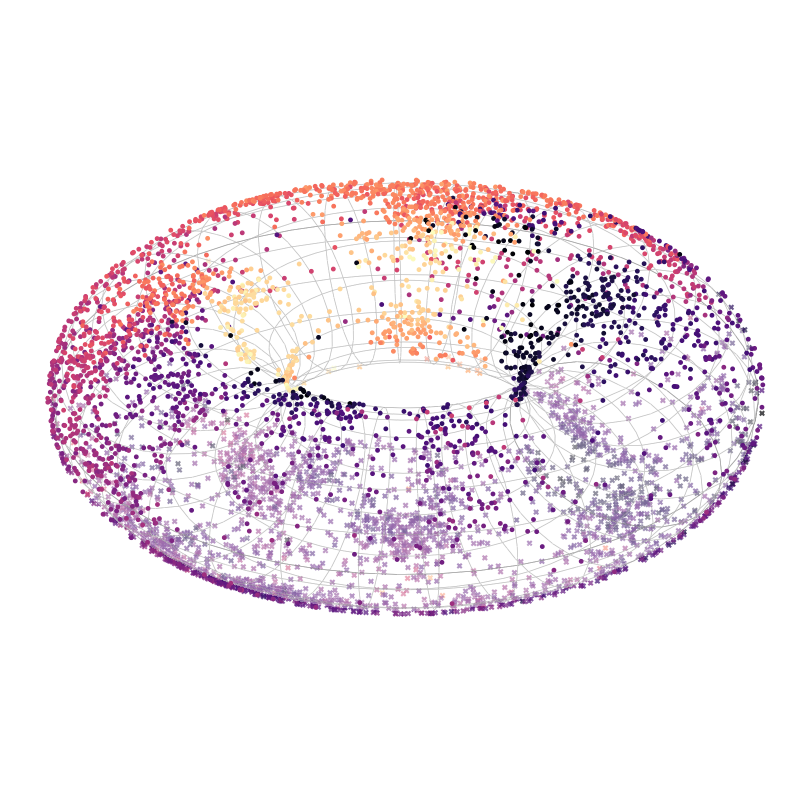

In [10]:
# Prepare data: concatenate splits 
z = np.concatenate([
    model_torus.z.detach().cpu().numpy(),
    model_torus.z_val.detach().cpu().numpy(),
    model_torus.z_test.detach().cpu().numpy()
], axis=0)

labels = np.concatenate([
    train_data.obs.cell_cycle_theta.values,
    val_data.obs.cell_cycle_theta.values,
    test_data.obs.cell_cycle_theta.values
], axis=0)

color_col = pd.concat([
    train_data.obs["color"],
    val_data.obs["color"],
    test_data.obs["color"]
], axis=0).reset_index(drop=True)
is_nonprolif = color_col.isna().values

R = 1.0
r = 0.5
theta = np.arctan2(z[:, 1], z[:, 0])
phi = np.arctan2(z[:, 3], z[:, 2])
theta, phi = phi, theta
z1 = (R + r * np.cos(phi)) * np.cos(theta)
z2 = (R + r * np.cos(phi)) * np.sin(theta)
z3 = r * np.sin(phi)
cmap = "magma"
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot proliferating cells (scatter, colored by label)
sc1 = ax.scatter(
    z1[~is_nonprolif],
    z2[~is_nonprolif],
    z3[~is_nonprolif],
    c=labels[~is_nonprolif],
    cmap=cmap,
    s=6,
    alpha=1,
    label="Proliferating"
)

# Plot non-proliferating cells as 'x'
sc2 = ax.scatter(
    z1[is_nonprolif],
    z2[is_nonprolif],
    z3[is_nonprolif],
    c=labels[is_nonprolif],
    cmap=cmap,
    s=10,
    alpha=0.7,
    marker="x",
    label="Non-proliferating",
    linewidths=1     # thin border
)

ax.set_axis_off()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

# generate torus mesh
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, 2*np.pi, 30)
u, v = np.meshgrid(u, v)

# parametric torus
X = ((R-0.01) + (r-0.01) * np.cos(v)) * np.cos(u)
Y = ((R-0.01) + (r-0.01) * np.cos(v)) * np.sin(u)
Z = (r-0.01) * np.sin(v)

ax.plot_wireframe(
    X, Y, Z,
    rstride=2, cstride=2,
    color='k',
    linewidth=0.5,
    alpha=0.5,
)
ax.plot_surface(
    X, Y, Z,
    color='white',
    alpha=0.2,
    linewidth=0,
    antialiased=False,
    shade=False
)
# ax.view_init(elev=30, azim=215)

plt.tight_layout()
# plt.savefig('results/pdfs/cc_torus_finalm.pdf', dpi=400, bbox_inches='tight')
# plt.savefig('results/pngs/cc_torus_finalm.png', dpi=400, bbox_inches='tight')
plt.show()
